Crameri2012Case1_Relaxation
======

This notebook reproduce the case 1 (a cosine perturbation of the surface) with true free surface in Crameri *et al.* (2012). 

**Keywords:** Sticky air, Free surface

**References**
1. Crameri, F., Schmeling, H., Golabek, G. J., Duretz, T., Orendt, R., Buiter, S. J. H., ... & Tackley, P. J. (2012). A comparison of numerical surface topography calculations in geodynamic modelling: an evaluation of the ‘sticky air’method. Geophysical Journal International, 189(1), 38-54.
![](./images/crameri2012case1.png)

In [1]:
from underworld import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

import underworld.function as fn
import math
import numpy as np

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

KL = 700 * u.kilometer
K_viscosity = 1e21  * u.pascal * u.second
K_density   = 3300 * u.kilogram / u.meter**3

KM = K_density * KL**3
Kt = KM/ ( KL * K_viscosity )

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [3]:
Model = GEO.Model(elementRes=(256,64),
                  minCoord=(0. * u.kilometer, 0. * u.kilometer),  
                  maxCoord=(2800. * u.kilometer, 700. * u.kilometer),
                  gravity=(0.0, -10 * u.meter / u.second**2))

dt = 1.*u.kiloyear
dt_str = "%.1f" %(dt.m)
checkpoint_interval = 1.*u.kiloyear
fdir = "1_23_03_FreeSurface_Crameri2012CaseCase1_Relaxation_dt"+dt_str+"ka"
Model.outputDir = fdir

In [4]:
wavelength = GEO.nd(Model.maxCoord[0])
amplitude  = GEO.nd(7*u.kilometer)
offset     = GEO.nd(700.*u.kilometer)
k = 2. * math.pi / wavelength

coord = fn.coord()
perturbationFn = offset + amplitude*fn.math.cos(k*coord[0])

li_Shape = coord[1] > GEO.nd(600*u.kilometer)
ma_Shape = coord[1] <= GEO.nd(600*u.kilometer)

li  = Model.add_material(name="Lithosphere", shape=li_Shape)
ma  = Model.add_material(name="Mantle Asthenosphere", shape=ma_Shape)

In [5]:
with Model.mesh.deform_mesh():
     Model.mesh.data[Model.top_wall.data, 1] = perturbationFn.evaluate(Model.top_wall)[:,0] 


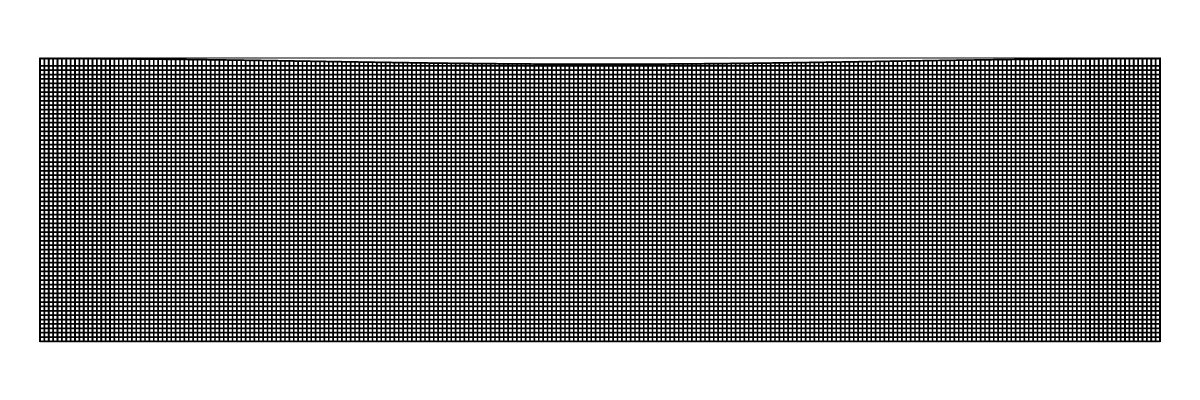

In [6]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Mesh(Model.mesh)
Fig.save("Fig_CrameriCase1_mesh0.png")
Fig.show()

In [7]:
npoints = 5000
coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = offset + amplitude*np.cos(k*coords[:, 0])
surf_tracers = Model.add_passive_tracers(name="Surface",vertices=coords)

# import matplotlib.pyplot as plt
# fig, ax1 = plt.subplots(nrows=1, figsize=(10,5))
# ax1.plot(surf_tracers.data[:,0],surf_tracers.data[:,1])
# ax1.plot(coords[:, 0],coords[:, 1],'r')
# ax1.plot(Model.mesh.data[Model.top_wall.data, 0],Model.mesh.data[Model.top_wall.data, 1],'k')


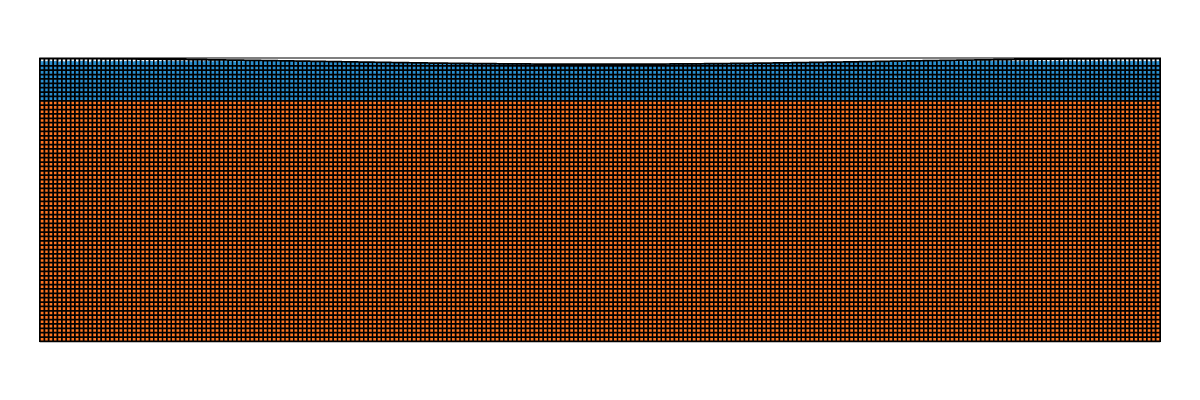

In [8]:
Fig = vis.Figure(figsize=(1200,400))
#Fig.Points(surf_tracers, pointSize=4.0)
Fig.Points(Model.swarm, Model.materialField,fn_size=2.0,discrete=True,colourBar=False)
Fig.Mesh(Model.mesh)
Fig.save("Fig_CrameriCase1_0.png")
Fig.show()

In [9]:
li.density = 3300. * u.kilogram / u.metre**3 
ma.density = 3300. * u.kilogram / u.metre**3

li.viscosity  =  1e23 * u.pascal * u.second                             
ma.viscosity  =  1e21 * u.pascal * u.second

In [10]:
Model.set_velocityBCs(left=[0., None], right=[0., None], top=[None, None], bottom=[0.,0.])
Model.freeSurface = True

In [11]:
Model.solver.set_inner_method("mumps")
GEO.rcParams['swarm.particles.per.cell.2D']=36

In [12]:
Model.run_for(0.1 * u.megayears, checkpoint_interval=checkpoint_interval,dt= dt)

Running with UWGeodynamics version 2.10.1-dev-dcb2ff4(development)
Options:  -Q22_pc_type uw -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 1000.0 year dt: 1000.0 year (2021-09-28 14:04:12)
Step:     2 Model Time: 2000.0 year dt: 1000.0 year (2021-09-28 14:04:35)
Step:     3 Model Time: 3000.0 year dt: 1000.0 year (2021-09-28 14:04:58)
Step:     4 Model Time: 4000.0 year dt: 1000.0 year (2021-09-28 14:05:21)
Step:     5 Model Time: 5000.0 year dt: 1000.0 year (2021-09-28 14:05:44)
Step:     6 Model Time: 6000.0 year dt: 1000.0 year (2021-09-28 14:06:06)
Step:     7 Model Time: 7000.0 year dt: 1000.0 year (2021-09-28 14:06:26)
Step:     8 Model Time: 8000.0 year dt: 1000.0 year (2021-09-28 14

1


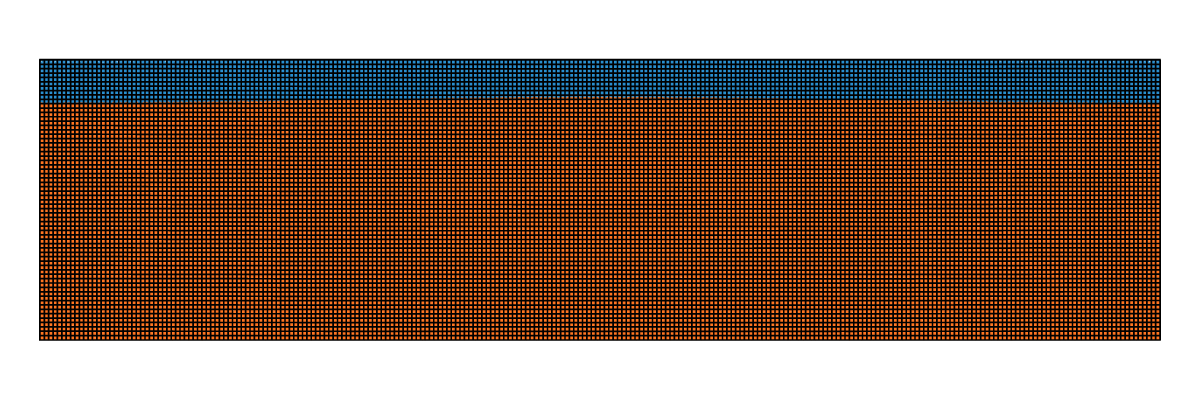

In [13]:
Fig.save("Fig_CrameriCase1_1.png")
Fig.show()

In [20]:
import h5py
import underworld as uw
import matplotlib.pyplot as plt

(xRes, yRes) = 256,64
def loadtopo(fdir,maxstep,dstep):
    depth_max = []
    for step in range(0,maxstep,dstep):
        mesh = uw.mesh.FeMesh_Cartesian(elementType = 'Q1/dQ0', 
                                 elementRes  = (xRes, yRes))
        meshfile = fdir+"mesh-"+ str(step)+".h5"
        mesh.load(meshfile)
        top = mesh.specialSets[ 'Top_VertexSet'] 
        ycoord = mesh.data[top.data, 1]
        depth_max.append(ycoord.max())  
    return np.array(depth_max)

In [18]:
dt1,maxstep1,dstep1,= 1,99,1 
times1 = np.arange(0,dt1*maxstep1-dt1*dstep1/2,dt1*dstep1)

gamma = -0.2139e-11
h_init = 7
tao = 1000*365.25*24*3600
h_analytic = h_init*np.exp(gamma*times1*tao)

fdir += "/"
h_calculate = loadtopo(fdir,maxstep1,dstep1)-700

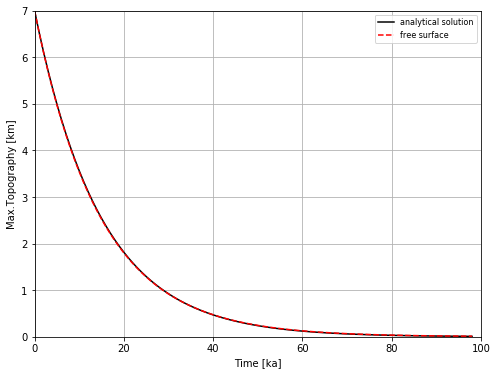

In [25]:
# Fig 2(a) in Crameri et al., 2012

fname = "Maximum topography of Case 1 over time"+ ".png"
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set(xlabel='Time [ka]', ylabel='Max.Topography [km]') 

ax.plot(times1,h_analytic,'k',label= "analytical solution")
ax.plot(times1,h_calculate,'--r',label= "free surface") 

ax.legend(loc = 'upper right',prop = {'size':8})
ax.set_xlim([0,100]) 
ax.set_ylim([0,7]) 
ax.grid()
plt.savefig(fname,dpi=150,bbox_inches='tight')